In [1]:
#!/usr/bin/env python
# coding: utf-8

# ## Data Cleaning and Preprocessing

# In[44]:


# Import dependencies
import pandas as pd
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password


# In[45]:


# Read in files
df = pd.read_csv('Resources/bitcoin_data.zip')


# In[46]:


# Display initial data
df.head(10)


# In[47]:


# Drop all nulls
# df = df.dropna()


# In[48]:


# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price']].reset_index(drop=True)
df


# In[49]:


# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)


# In[50]:


# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# .strftime('%Y-%m-%d %H:%M:%S')
    
# Convert from Unix to UTC time
#df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].\
#    apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))


# In[51]:


# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")


# In[52]:


# calculating UTC time deltas
final_df['time_delta'] = (final_df['UTC_time'] - final_df['UTC_time'].shift())

# creating mask to filter deltas
mask = final_df['time_delta'].apply(lambda x: True if x <= pd.Timedelta('0 days 00:01:00') else False)

# invert mask to create df with significant data loss
deltas_df = final_df[~mask]


# In[53]:


# shows longest periods of data loss
sorted_deltas_df = deltas_df.sort_values('time_delta', ascending=False, ignore_index=False)
sorted_deltas_df


# In[54]:


# shows periods of data loss where weighted price was highest
sorted_prices_df = deltas_df.sort_values('Weighted_Price', ascending=False, ignore_index=False)
sorted_prices_df


# In[55]:


# Machine learning section
# possible implementation ideas:
# 1. time series forecasting bitcoin price with ARIMA(Auto Regressive Integrated Moving Average)
# Rational for using time series: the 4 components of time series are trends, seasonality (consistent trends that span 1 calender year), noise/irregularity, and cyclicity(trends that can be observed in <1 or >1 year); this is perfect for tradeable assets 
# Qualifying criteria: the dataset must be stationary in order to more accurately fit a time series model. Stationary means that there should be a constant mean with constant std deviation or variance
# We can test if a time series is stationary by plotting the moving avg and/or movning std dev. to see if it changes over time. These results can be supported with an ADCF test
# if testing reveals our time series is NOT stationary, we can perform a variety of transformations to change it (log transform, sq rt, exponential decay etc..)
# SARIMA is ARIMA with a seasonality component. 


# ### PGAdmin SQL Schema

# In[56]:


# db schema thoughts: can create multiple tables for each currency (1 for btc, 1 ethereum, 1 xrp)
# can also add in additional tables down the line to support our analysis (table with google analytics, table with twitter search results for sentiment analysis)


# In[57]:


# View final dataset column names
final_df.head(5)


# In[58]:


# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC',
                  'time_delta':'timeDelta'
                 }, axis='columns', inplace=True)


# In[59]:


# Converting timedelta to string
final_df = final_df.astype({'timeDelta':'str'})


# In[60]:


# Checking datatypes
final_df.dtypes


# In[61]:


# Verifying final dataframe
final_df.head(2)




Percentage of total Bitstamp data lost due to dropping rows with NaN values: 27.14%
Ratio of Bitstamp rows dropped: 1,240,496/4,571,033
Total dataset contains 3174.33 days worth of data. Due to data loss, we had to drop 861.46 days worth of data


,timestamp,high,low,volume,weightedPrice,timestampSTR,timestampINT,timeUTC,timeDelta
0,1325391360,4.58,4.58,1.502,4.58,1325391360,1325391360,2012-01-01 04:16:00,NaT
1,1325431680,4.84,4.84,10.000,4.84,1325431680,1325431680,2012-01-01 15:28:00,0 days 11:12:00.000000000


In [2]:
# importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima as AA
import warnings
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
import regex as re

# error evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# suppress harmless deprecation warnings
warnings.filterwarnings("ignore")

# importing dataset
#system_forecasts = pd.read_csv('datasets/systems_copied.csv', parse_dates=True, index_col=0)

#transposed = system_forecasts.transpose()
#transposed.replace(',','', regex=True, inplace=True)    # removing all commas from dataframe
#transposed.index = pd.to_datetime([re.sub(r'[US]*[US]*',r'', value) for value in transposed.index.values])

# transforming dataset (dates reversed)
#reversed_transposed = transposed.iloc[::-1]


def rename_columns():
    new_cols = {}
    orig_column_names = reversed_transposed.columns.tolist()
    new_column_names = [sku.replace(' ','') for sku in orig_column_names]
    for i in range(len(orig_column_names)):
        new_cols[orig_column_names[i]] = new_column_names[i]
    return new_cols

#cleaned_transposed = reversed_transposed.rename(columns=rename_columns())
#print(cleaned_transposed)


#header_row = cleaned_transposed.columns.tolist()
# visualizes separate components of a time series (Error, Trend, Seasonality, Residuals)
def get_ETS_visuals():
    curr_dir = os.getcwd()
    my_path = curr_dir + '/ETS_decomp_visuals'
    for i in range(len(header_row)):
        ETS_decomp = seasonal_decompose(cleaned_transposed[header_row[i]], model='additive')
        ETS_decomp.plot()
        my_file = (f'{header_row[i]}_ETS_decomp_visualization.png')  # naming visualization
        plt.savefig(os.path.join(my_path, my_file))
        plt.clf()

def get_ARIMA_visuals(header_row,i):
    curr_dir = os.getcwd()
    my_path = curr_dir + '/ARIMA_predictions'
    my_file = (f'{header_row[i]}_forecast.png')  # naming visualization
    plt.savefig(os.path.join(my_path, my_file))
    plt.clf()

#DataFrameDict = {sku: pd.DataFrame for sku in header_row}
#for key in DataFrameDict.keys():
#    DataFrameDict[key] = cleaned_transposed[key]


def forecast(dataframe, model, sku_name):
    curr_dir = os.getcwd()
    my_path = curr_dir + '/ARIMA_forecasts'

    # Forecast for next 1 year
    forecast = model.predict(start=len(dataframe),
                              end=(len(dataframe) - 1) + 1 * 12,
                              typ='levels').rename('Forecast')

    # Plot the forecast values
    dataframe.plot(figsize=(12, 5), legend=True)
    forecast.plot(legend=True)
    my_file = (f'{sku_name}_prediction.png')  # naming visualization
    plt.savefig(os.path.join(my_path, my_file))
    plt.clf()


# splits data into training and test datasets, outputs forecasted values
def train_test_predict():
    curr_dir = os.getcwd()
    my_path = curr_dir + '/ARIMA_predictions'
    error_dict = {}

    for header in header_row:
        print(f'-------------------Now analyzing {header} -------------------')
        # call AA to identify optional params and return fitted model
        df = DataFrameDict[header]
        stepwise_fit = AA(df, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
        print(stepwise_fit.get_params()['seasonal_order'])
        # Split data into train / test sets
        train = df.iloc[:len(df) - 12]  # allocate all but 12 mo data for training
        test = df.iloc[len(df) - 12:]  # 12 mo data for testing

        try:    # try producing predicted values
            model = SARIMAX(train,
                            order=stepwise_fit.get_params()['order'],
                            seasonal_order=stepwise_fit.get_params()['seasonal_order'])

            result = model.fit()
            forecast(df, result, header)    # calculating 1 year forecast

            # calculating predicted values
            start = len(train)
            end = len(train) + len(test) - 1

            # Predictions for one-year against the test set
            predictions = result.predict(start, end, typ='levels').rename("Predictions")

            # graphing actual vs predicted values
            predictions.plot(figsize=(12,5), label='Predicted #')
            test.plot(label='Actual #')
            plt.legend()
            plt.ylabel('Quantity')
            plt.xlabel('Month')
            plt.title(f'{header} predicted vs actual demand')
            #get_ARIMA_visuals(header_row, i)

            my_file = (f'{header}_prediction.png')  # naming visualization
            plt.savefig(os.path.join(my_path, my_file))
            plt.clf()

            # generating error report
            error_dict[header] = [rmse(test, predictions),mean_squared_error(test, predictions)]
        except:
            print(f'Analysis for {header} failed.. skipping')
            error_dict[header] = ['null','null']
            pass

    error_log = pd.DataFrame.from_dict(error_dict, orient='index', columns=['RMSE','MSE'])
    error_log.to_csv('prediction_error_log.csv')

#print(train_test_predict())
'''
if __name__ == '__main__':
    get_ETS_visuals()
    train_test_predict()
'''

"\nif __name__ == '__main__':\n    get_ETS_visuals()\n    train_test_predict()\n"

In [3]:
date_price_df = final_df[['timeUTC','weightedPrice']]

In [4]:
btc_2012_to_2017_df = date_price_df[date_price_df['timeUTC'].dt.date <= pd.to_datetime('2017-01-01')]

In [5]:
y=btc_2012_to_2017_df.set_index(['timeUTC'])
y.sort_index(inplace=True)
y.dropna(inplace=True)
y['weightedPrice']

timeUTC
2012-01-01 04:16:00      4.580000
2012-01-01 15:28:00      4.840000
2012-01-01 22:45:00      5.000000
2012-01-02 20:04:00      5.000000
2012-01-03 11:45:00      5.320000
                          ...    
2017-01-01 23:55:00    997.400000
2017-01-01 23:56:00    997.400000
2017-01-01 23:57:00    997.493394
2017-01-01 23:58:00    997.657274
2017-01-01 23:59:00    997.631291
Name: weightedPrice, Length: 1470241, dtype: float64

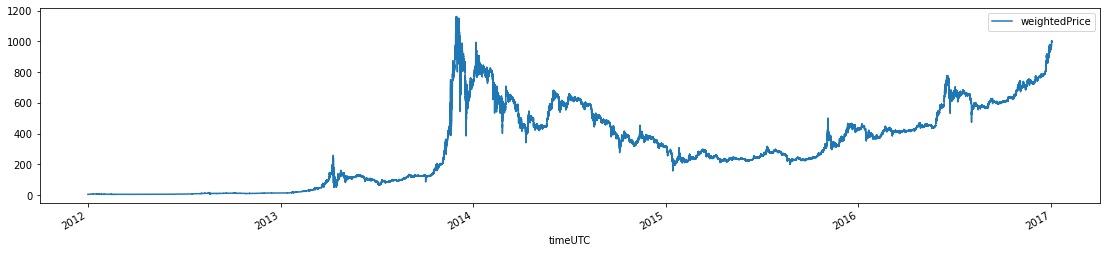

In [6]:
y.plot(figsize=(19,4))

# later try to plot each year on its own axis to try and identify seasonality/cyclicity

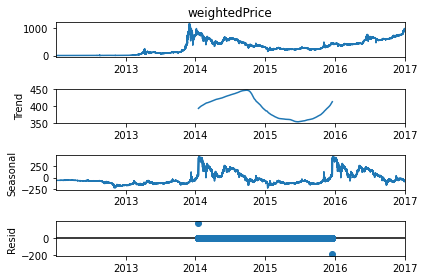

In [7]:
# seasonal decomposition
decomposition = seasonal_decompose(y['weightedPrice'], model='additive', period = int(len(y)/2))
fig = decomposition.plot()
plt.show()

In [8]:
# importing and setting dependencies
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [9]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y['weightedPrice'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:22206080.742331084
